In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
sheet = pd.read_excel('data_input_auto/柴油独立炼厂库存.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['中国独立炼厂柴油库存'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,中国独立炼厂柴油库存,中国独立炼厂柴油表需,柴油：独立炼厂：产量：中国（周）
2025-05-26,NaN,NaN,NaN
2025-05-27,NaN,NaN,NaN
2025-05-28,NaN,NaN,NaN
2025-05-29,NaN,NaN,NaN
2025-05-30,NaN,NaN,NaN


In [4]:
last_day

Timestamp('2025-05-02 00:00:00')

In [5]:
file_path1 = os.path.expanduser("eta/柴油独立炼厂表需_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()
sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.head()

,Date,预测值
29,2025-04-28,174.4
28,2025-04-29,156.5
27,2025-04-30,157.7
26,2025-05-01,166.6
25,2025-05-02,166.6


In [6]:
file_path2 = os.path.expanduser("eta/柴油独立炼厂产量_合并数据.xlsx") 
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.drop(columns=['真实值'])
sheet2 = sheet2.dropna()
sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2.head()

,Date,预测值
5,2025-05-09,167.3
4,2025-05-16,175.2
3,2025-05-23,172.7
2,2025-05-30,162.9
1,2025-06-06,172.6


In [7]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['中国独立炼厂柴油表需'] = sheet_daily['中国独立炼厂柴油表需'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['柴油：独立炼厂：产量：中国（周）'] = sheet_daily['柴油：独立炼厂：产量：中国（周）'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-03-01')]
# 将数据转换为周度数据(每周五)
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
sheet_daily['weekday'] = sheet_daily['Date'].dt.weekday  # 0=周一,4=周五
sheet_daily = sheet_daily[sheet_daily['weekday'] == 4]
sheet_daily = sheet_daily.drop('weekday', axis=1)
sheet_daily = sheet_daily.copy()
sheet_daily

,Date,中国独立炼厂柴油库存,中国独立炼厂柴油表需,柴油：独立炼厂：产量：中国（周）
147,2023-03-03,128.3670,177.6116,178.2496
148,2023-03-10,126.8930,177.6486,176.1746
149,2023-03-17,127.6480,169.1405,169.8955
150,2023-03-24,140.8890,166.5615,179.8025
151,2023-03-31,148.8310,173.0055,180.9475
...,...,...,...,...
260,2025-05-02,NaN,166.6000,167.3400
265,2025-05-09,NaN,168.6000,167.3000
270,2025-05-16,NaN,166.1000,175.2000
275,2025-05-23,NaN,163.9000,172.7000


In [8]:
sheet_daily['中国独立炼厂柴油库存_环差'] = sheet_daily['柴油：独立炼厂：产量：中国（周）'] - sheet_daily['中国独立炼厂柴油表需']
sheet_daily['中国独立炼厂柴油库存_预测'] = sheet_daily['中国独立炼厂柴油库存'].shift(1) + sheet_daily['中国独立炼厂柴油库存_环差']

In [9]:

for i in range(1, len(sheet_daily)):
    if pd.isna(sheet_daily.at[sheet_daily.index[i], '中国独立炼厂柴油库存_预测']):
        sheet_daily.at[sheet_daily.index[i], '中国独立炼厂柴油库存_预测'] = sheet_daily.at[sheet_daily.index[i-1], '中国独立炼厂柴油库存_预测'] + sheet_daily.at[sheet_daily.index[i], '中国独立炼厂柴油库存_环差']

sheet_daily.tail()

,Date,中国独立炼厂柴油库存,中国独立炼厂柴油表需,柴油：独立炼厂：产量：中国（周）,中国独立炼厂柴油库存_环差,中国独立炼厂柴油库存_预测
260,2025-05-02,NaN,166.60,167.34,0.74,140.8404
265,2025-05-09,NaN,168.60,167.30,-1.30,139.5404
270,2025-05-16,NaN,166.10,175.20,9.10,148.6404
275,2025-05-23,NaN,163.90,172.70,8.80,157.4404


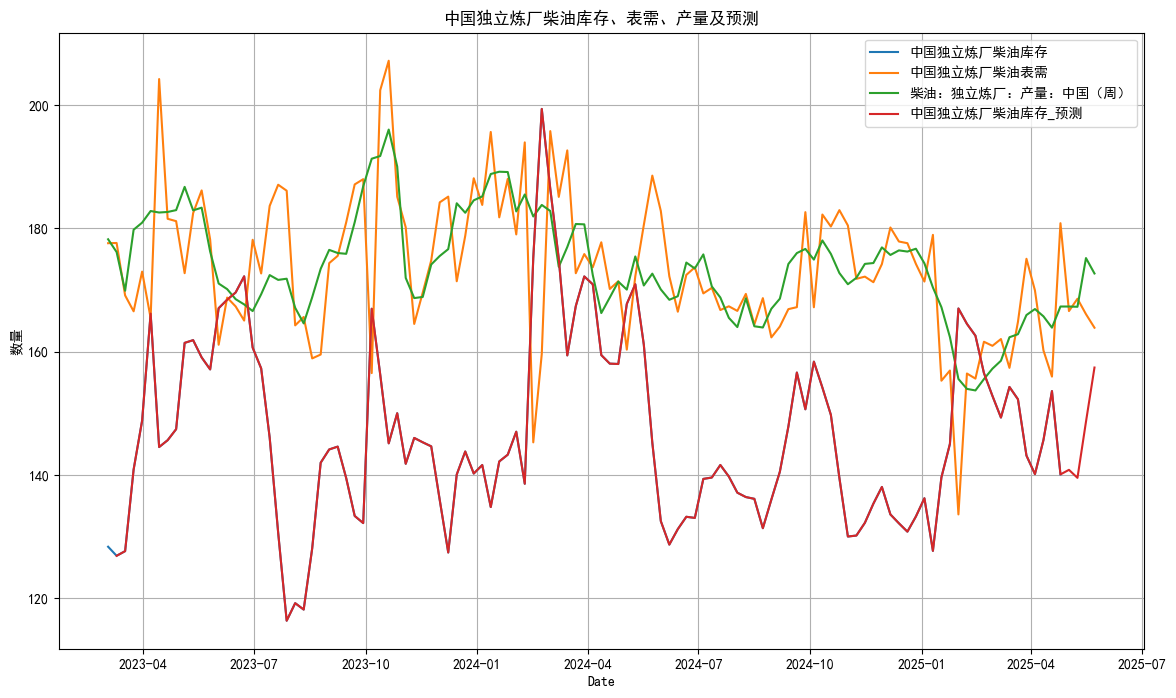

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

plt.plot(sheet_daily['Date'], sheet_daily['中国独立炼厂柴油库存'], label='中国独立炼厂柴油库存')
plt.plot(sheet_daily['Date'], sheet_daily['中国独立炼厂柴油表需'], label='中国独立炼厂柴油表需')
plt.plot(sheet_daily['Date'], sheet_daily['柴油：独立炼厂：产量：中国（周）'], label='柴油：独立炼厂：产量：中国（周）')
plt.plot(sheet_daily['Date'], sheet_daily['中国独立炼厂柴油库存_预测'], label='中国独立炼厂柴油库存_预测')

plt.xlabel('Date')
plt.ylabel('数量')
plt.title('中国独立炼厂柴油库存、表需、产量及预测')
plt.legend()
plt.grid(True)
plt.show()


---

In [11]:
# 创建新的 dataframe merged_df_daily
merged_df_daily = sheet_daily[['Date','中国独立炼厂柴油库存', '中国独立炼厂柴油库存_预测']].copy()
merged_df_daily.loc[merged_df_daily['Date'] <= last_day, '中国独立炼厂柴油库存_预测'] = None
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/柴油独立炼厂库存_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_daily.head()

,Date,中国独立炼厂柴油库存,中国独立炼厂柴油库存_预测
280,2025/05/30,NaN,144.2744
275,2025/05/23,NaN,157.4404
270,2025/05/16,NaN,148.6404
265,2025/05/09,NaN,139.5404
260,2025/05/02,NaN,140.8404
259,2025/04/25,140.1004,NaN


In [12]:
merged_df_monthly = sheet_daily[['Date','中国独立炼厂柴油库存', '中国独立炼厂柴油库存_预测']].copy()
merged_df_monthly.loc[merged_df_monthly['Date'] <= '2024-10-1', '中国独立炼厂柴油库存_预测'] = None
merged_df_monthly['Date'] = pd.to_datetime(merged_df_monthly['Date'])
merged_df_monthly = merged_df_monthly.resample('ME', on='Date').last().reset_index()
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/柴油独立炼厂库存_月度数据.xlsx', index=False, float_format='%.2f')
merged_df_monthly.head()

,Date,中国独立炼厂柴油库存,中国独立炼厂柴油库存_预测
26,2025/05/31,NaN,157.4404
25,2025/04/30,140.1004,140.1004
24,2025/03/31,143.1604,143.1604
23,2025/02/28,152.8390,152.8390
22,2025/01/31,167.0214,167.0214


In [13]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "柴油独立炼厂库存"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [14]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "柴油独立炼厂库存"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/04/30)
数据已成功更新到Excel文件
